In [ ]:
%matplotlib widget
%reset -f
%load_ext autoreload
%autoreload 1
%aimport mechanics

from sympy import *
from mechanics import *
import mechanics.config

mechanics.config.diff_notations = {}

t, x = base_spaces('t x')

u, = variables('u', t, x)
c, L = constants('c L')
    
eq = {diff(u, t, t): c**2 * diff(u, x, x)}
show_equations(eq)

# bc_0 = { diff(u, x).subs(x, 0): 0 }
bc_0 = { u.subs(x, 0): 0 }
bc_L = { diff(u, x).subs(x, L): 0 }
# bc_L = { u.subs(x, L): 0 }
show_equations(bc_0)
show_equations(bc_L)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [48]:
from mechanics.difference import second_central, central
from mechanics.space import Z

i, j = indices('i j')
h, k = constants('h k')
N, M = constants('N M', space=Z)

d = discretization()\
    .space(t, i, h).diff(t, second_central)\
    .space(x, j, k).diff(x, second_central).diff(x, central)

u = d(u)

eq_d = d(eq)
show_equations(eq_d)

eq_d = solve(to_implicit(eq_d), u[i+1,j])
show_equations(eq_d)

bc_d = d(bc)
show_equations(bc_d)
# bc_d = solve((f.subs(L/k, M) for f in to_implicit(bc_d)), (u[:,-1], u[:,M+1]))
bc_d = {l.subs(L/k, M): r.subs(L/k, M) for l, r in bc_d.items()}
show_equations(bc_d)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [61]:
%autoreload
solver = build_solver()
solver.constants(c, h, k, N, M)
solver.variables(u, indices=((i, -1, N), (j, 0, M)))
solver.inputs(u[0,:], u[-1,:])
with solver.steps(i, 0, N) as step_time:
    step_time.explicit(bc_d)
    with step_time.steps(j, 1, M) as step_space:
        step_space.explicit(eq_d)
solver = solver.generate()

Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp2pc7aqck/generated.f90


In [80]:
%autoreload
import numpy as np

_ = solver.run({
    c: 1.0, 
    h: 0.01, k: 0.01, 
    N: 500, M: 500,
    u[0,:]:  1 - np.tanh((np.arange(0, 501) * 0.01 - 0.5) * 5)**2,
    u[-1,:]: 1 - np.tanh((np.arange(0, 501) * 0.01 - 0.5) * 5)**2,
    # u[0,:]:  np.sin((np.arange(0, 501) * 0.01 * np.pi)),
    # u[-1,:]:  np.sin((np.arange(0, 501) * 0.01 * np.pi)),
})

Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpjzquxxxg/result.log, size=251507


/var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/ipykernel_87936/3763176360.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"projection": "3d"}, tight_layout=True)


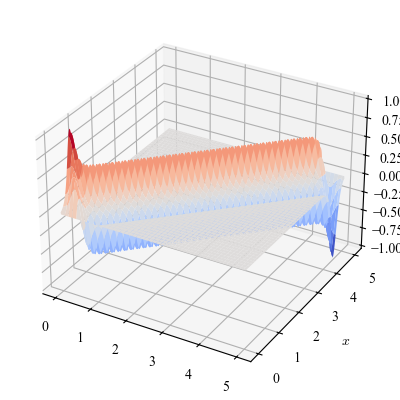

In [81]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

# t = np.arange(0, _[T], _[h])

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"projection": "3d"}, tight_layout=True)
T = np.arange(0, _[N]+2) * _[h]
X = np.arange(0, _[M]+1) * _[k]
T, X = np.meshgrid(T, X, indexing='ij')
ax.plot_surface(T, X, _[u], cmap='coolwarm')
ax.set_ylabel('$x$')
ax.set_zlabel('$u$')
plt.show()
